## Master's Thesis: Evaluation methods in Numerical Weather Prediction

In this Jupyter Notebook, I am evaluating 4 different temporal splitting strategies over three different datasets: KNMI dataset, Brazil weather dataset and Europe weather dataset.

Temporal data splitting strategies: 

a) Random 

b) Validation and test at the end with the size of one block 

c) Validation and test somewhere in the dataset with the size of one block 

d) Validation and test divided into some smaller parts (3-4) somewhere in the dataset 

### Imports

In [6]:
import numpy as np
import pandas as pd
import gzip
import random
import itertools
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### I. KNMI data

In [ ]:
with gzip.open("./Datasets/kis_toa_200304.gz", mode="rt") as f:
    content = f.readlines()
count = 0
for line in content:
    if count > 18:
        break
    print(line.strip())
    count += 1

### II. Brazil data

Attempted to work with this dataset, but 20 to 25% of the data is NaN

In [ ]:
# central_west = pd.read_csv("./Datasets/Brazil_dataset/central_west.csv")
north = pd.read_csv("./Datasets/Brazil_dataset/north.csv")
description = pd.read_csv("./Datasets/Brazil_dataset/columns_description.csv")
description.abbreviation[19] = 'reg'

In [ ]:
new_columns = {}
for i in range(len(description.abbreviation)):
    new_columns[north.columns[i + 1]] = description.abbreviation[i]
def process_data_brazil(df):
    df = df.rename(columns = new_columns)
    df = df[df.date >= '2011-01-01']
    df = df.reset_index(drop=True)
    df = df.drop(columns = ['gbrd'])
    df['time'] = df['date'] + " " + df['hr']
    pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=['date', 'hr'])
    time = df.pop("time")
    df.insert(1, "time", time)
    return df
north = process_data_brazil(north)
north

In [ ]:
# north = north[north.date >= '2011-01-01']
# north = north.reset_index(drop=True)
# north = north.drop(columns=['gbrd'])

In [ ]:
# north[(north.prcp == -9999) & (north.stp == -9999) & (north.smax == -9999)]
# north.query('prcp == -9999 and stp == -9999 and temp == -9999')

In [ ]:
north['time'] = north['date'] + " " + north['hr']
pd.to_datetime(north['time'], format='%Y-%m-%d %H:%M')
north = north.drop(columns=['date', 'hr'])
time = north.pop("time")
north.insert(1, "time", time)

In [ ]:
north

### III. Europe data

In [7]:
def makeSlidingWindow(dataset: pd.DataFrame, window_size: int, output_size: int, step_size: int, column_name: str) -> pd.DataFrame:
    '''Sliding window for transforming a Time Series into a Supervised ML problem'''

    # Shift the dataset to form the feature matrix (X) with window size and the target matrix (y) with output size
    # X1 is later than X0 and y1 is later than y0
    for i in range(window_size):
        dataset['X{}'.format(i)] = dataset[column_name].shift(-i)
    for i in range(output_size):
        dataset['y{}'.format(i)] = dataset[column_name].shift(-window_size - i)

    # Drop the NaN values
    dataset.dropna(inplace=True)

    # Format the feature matrix (X) and the target matrix (y) such that they respect the step size
    X = dataset[['X{}'.format(i) for i in range(window_size)]]
    X = X.iloc[::step_size]
    y = dataset[['y{}'.format(i) for i in range(output_size)]]
    y = y.iloc[::step_size]
    return pd.concat([X, y], axis=1)

In [8]:
def makeDatasets(dataset: pd.DataFrame, column: str) -> list[pd.DataFrame]:
    '''
    Takes only the features desired from all cities and makes the date an index
    '''
    datasets = []
    for col in dataset.filter(like=column, axis=1).columns:
        datasets.append(dataset[['DATE', col]].set_index('DATE'))
    return datasets

In [9]:
def makeSplittings(dataset: pd.DataFrame, type: str, period: int, seasons: int) -> list[pd.DataFrame]:
    '''
    a -> random
    b -> test after validation after train
    c -> validation and test in between training data
    d -> same as c, but more fragmented
    '''
    split_dataset = []
    if type == 'a':
        # Strategy a, take random points from the dataset
        train_val, test = train_test_split(dataset, test_size=len(dataset) // 10)
        train, val = train_test_split(train_val, test_size=len(dataset) // 10)
        split_dataset.append(train.sort_index())
        split_dataset.append(val.sort_index())
        split_dataset.append(test.sort_index())
    elif type == 'b':
        # Strategy b, take the last period of time as test set and the previous period of time as validation set
        a = random.randint(2, (len(dataset) // period) - 2)
        split_dataset.append(dataset.iloc[:a*period])
        split_dataset.append(dataset.iloc[a*period:(a+1)*period])
        split_dataset.append(dataset.iloc[(a+1)*period:(a+2)*period])
    elif type == 'c':
        # Strategy c, take one random period of time as test set (same with validation set)
        a = random.sample(range(1, (len(dataset) // period) - 1), 2)
        x = dataset.iloc[:a[0]*period if a[0] < a[1] else a[1]*period]
        y = dataset.iloc[(a[0]+1)*period if a[0] < a[1] else (a[1]+1) * period : a[1] * period if a[0] < a[1] else a[0] * period]
        z = dataset.iloc[(a[1]+1)*period if a[0] < a[1] else (a[0]+1)*period:]
        split_dataset.append(pd.concat([x, y, z], axis=0))
        split_dataset.append(dataset.iloc[a[0]*period:(a[0]+1)*period])
        split_dataset.append(dataset.iloc[a[1]*period:(a[1]+1)*period])
    elif type == 'd':
        # Strategy d, take multiple smaller blocks of time as a test / validation set and distribute them randomly
        # The smaller blocks should cover a period of time
        a = []
        a.append(np.random.choice(len(dataset) // period, seasons))
        while True:
            check = 0
            b = np.random.choice(len(dataset) // period, seasons)
            for elem in list(zip(a[0], b)):
                if elem[0] == elem[1]:
                    check = 1
                    break
            if check == 0:
                a.append(b)
                break

        elements = []
        for i in range(seasons):
            elements.append(dataset.iloc[a[0][i] * period + i * (period // seasons) : a[0][i] * period + (i+1) * (period // seasons)])
        validation = pd.concat(elements, axis = 0)

        elements = []
        for i in range(seasons):
            elements.append(dataset.iloc[a[1][i] * period + i * (period // seasons) : a[1][i] * period + (i+1) * (period // seasons)])
        test = pd.concat(elements, axis=0)

        train = dataset.drop(validation.index)
        train = train.drop(test.index)
        split_dataset = [train, validation, test]

    else:
        print("No valid type")
        return []
    return split_dataset

In [10]:
def allTemporalSplittings(dataset: pd.DataFrame, type: str, sample_number: int, period: int, seasons: int) -> list[list[pd.DataFrame]]:
    '''
    a -> random
    b -> test after validation after train
    c -> validation and test in between training data
    d -> same as c, but more fragmented
    '''
    split_dataset = []
    if type == 'a':
        # Strategy a, take random points from the dataset
        for i in range(sample_number):
            train_val, test = train_test_split(dataset, test_size=len(dataset) // 10, random_state=i)
            train, val = train_test_split(train_val, test_size=len(dataset) // 10, random_state=i)
            split_dataset.append([train.sort_index(), val.sort_index(), test.sort_index()])
    elif type == 'b':
        # Strategy b, take the last period of time as test set and the previous period of time as validation set
        if sample_number > 2 * (len(dataset) // period) - 3:
            for a in range(1, (len(dataset) // period) - 1):
                train = dataset.iloc[:a*period]
                val = dataset.iloc[a*period:(a+1)*period]
                test = dataset.iloc[(a+1)*period:(a+2)*period]
                split_dataset.append([train, val, test])
            for a in range(((len(dataset) // period) - 2)):
                train = dataset.iloc[a*period:((len(dataset) // period) - 2) * period]
                val = dataset.iloc[((len(dataset) // period) - 2) * period:((len(dataset) // period) - 1) * period]
                test = dataset.iloc[((len(dataset) // period) - 1) * period:]
                split_dataset.append([train, val, test])
        else:
            a_samples = []
            for i in range(sample_number):
                while True:
                    a = random.randint(1, (len(dataset) // period) - 1)
                    if a not in a_samples:
                        break
                a_samples.append(a)
                train = dataset.iloc[:a*period]
                val = dataset.iloc[a*period:(a+1)*period]
                test = dataset.iloc[(a+1)*period:(a+2)*period]
                split_dataset.append([train, val, test])
    elif type == 'c':
        # Strategy c, take one random period of time as test set (same with validation set)
        if sample_number > len(list(itertools.permutations(range((len(dataset) // period)), 2))):
            for a in list(itertools.permutations(range((len(dataset) // period)), 2)):
                x = dataset.iloc[:a[0]*period if a[0] < a[1] else a[1]*period]
                y = dataset.iloc[(a[0]+1)*period if a[0] < a[1] else (a[1]+1) * period : a[1] * period if a[0] < a[1] else a[0] * period]
                z = dataset.iloc[(a[1]+1)*period if a[0] < a[1] else (a[0]+1)*period:]
                train = pd.concat([x, y, z], axis=0)
                val = dataset.iloc[a[0]*period:(a[0]+1)*period]
                test = dataset.iloc[a[1]*period:(a[1]+1)*period]
                split_dataset.append([train, val, test])
        else:
            a_samples = []
            for i in range(sample_number):
                while True:
                    a = random.sample(range((len(dataset) // period)), 2)
                    if a not in a_samples:
                        break
                a_samples.append(a)
                x = dataset.iloc[:a[0]*period if a[0] < a[1] else a[1]*period]
                y = dataset.iloc[(a[0]+1)*period if a[0] < a[1] else (a[1]+1) * period : a[1] * period if a[0] < a[1] else a[0] * period]
                z = dataset.iloc[(a[1]+1)*period if a[0] < a[1] else (a[0]+1)*period:]
                train = pd.concat([x, y, z], axis=0)
                val = dataset.iloc[a[0]*period:(a[0]+1)*period]
                test = dataset.iloc[a[1]*period:(a[1]+1)*period]
                split_dataset.append([train, val, test])
    elif type == 'd':
        # Strategy d, take multiple smaller blocks of time as a test / validation set and distribute them randomly
        # The smaller blocks should cover a period of time
        a = list(itertools.product(range(len(dataset) // period), repeat=seasons))
        b = list(itertools.permutations(a, 2))
        sampled = []
        for i in range(sample_number):
            while True:
                check = 0
                elem = np.random.choice(len(b))
                if elem in sampled:
                    continue
                x, y = b[elem]
                for j in range(len(x)):
                    if x[j] == y[j]:
                        check = 1
                        break
                if check == 0:
                    sampled.append(b[elem])
                    break

        for j in range(sample_number):
            elements = []
            for i in range(seasons):
                elements.append(dataset.iloc[sampled[j][0][i] * period + i * (period // seasons) : 
                                             sampled[j][0][i] * period + (i+1) * (period // seasons)])
            validation = pd.concat(elements, axis = 0)

            elements = []
            for i in range(seasons):
                elements.append(dataset.iloc[sampled[j][1][i] * period + i * (period // seasons) : 
                                             sampled[j][1][i] * period + (i+1) * (period // seasons)])
            test = pd.concat(elements, axis=0)

            train = dataset.drop(validation.index)
            train = train.drop(test.index)
            split_dataset.append([train, validation, test])

    else:
        print("No valid type")
        return []
    return split_dataset

i - city

j - type of splitting strategy

k - train - val - test

In [11]:
# Importing and cleaning the dataset
def prepareDataFrames(df: pd.DataFrame, feature: str, city: str, output: int, window: int, step: int) -> tuple[list[list[pd.DataFrame]], list[list[list[pd.DataFrame]]]]:
    df = df.drop(columns=['MONTH'])
    df['DATE'] = pd.to_datetime(df["DATE"], format="%Y%m%d")
    cities_list = list(df.filter(like=feature, axis=1).columns)
    cities_list = [x.replace('_{}'.format(feature), '') for x in cities_list]
    city_index = cities_list.index(city)
    cities_datasets = makeDatasets(df, feature)
    split = ['b', 'c', 'd']

    # Split and then transform the data for b, c and d strategy
    cities_split = []
    for i in split:
        cities_split.append(allTemporalSplittings(cities_datasets[city_index], i, sample_number=2000, period=365, seasons=4))

    # Scale the dataset
    for i in range(len(cities_split)):
        for j in range(len(cities_split[i])):
            scaler = StandardScaler()
            cities_split[i][j][0]['{}_{}'.format(city, feature)] = scaler.fit_transform(cities_split[i][j][0])
            cities_split[i][j][1]['{}_{}'.format(city, feature)] = scaler.transform(cities_split[i][j][1])
            cities_split[i][j][2]['{}_{}'.format(city, feature)] = scaler.transform(cities_split[i][j][2])
            
    cities_final = []
    # Range of strategies
    for i in range(3):
        cities_j = []
        # Range of combinations
        for j in range(len(cities_split[i])):
            cities_k = []
            # Range of type of dataset (train, val, test)
            for k in range(3):
                cities_k.append(makeSlidingWindow(cities_split[i][j][k], window, output, step, column_name=cities_split[i][j][k].columns[0]))
            cities_j.append(cities_k)
        cities_final.append(cities_j)

    # Transform and then split the data for a strategy
    cities_transformed = []
    for city_df in cities_datasets:
        cities_transformed.append(makeSlidingWindow(city_df, window, output, step, column_name=city_df.columns[0]))
    cities_a = allTemporalSplittings(cities_transformed[city_index], 'a', sample_number=2000, period=365, seasons=4)

    # Scale the dataset
    for i in range(len(cities_a)):
        scaler = StandardScaler()
        cities_a[i][0].iloc[:, :] = scaler.fit_transform(cities_a[i][0])
        cities_a[i][1].iloc[:, :] = scaler.transform(cities_a[i][1])
        cities_a[i][2].iloc[:, :] = scaler.transform(cities_a[i][2])

    return (cities_a, cities_final)
    

#### III.1 Trying different models and splits
Models: 
- Linear regression
- Support Vector Regressor
- Random Forest Regressor

In [12]:
def predictAndPlot(model, window: int, dataset: tuple[list[list[pd.DataFrame]], list[list[list[pd.DataFrame]]]]) -> pd.DataFrame:
    cities_a, cities_final = dataset
    split = ['b', 'c', 'd']
    values_train = []
    values_val = []
    values_test = []
    table_lin_reg = pd.DataFrame()
    
    # Range of combinations
    for i in range(len(cities_a)):
        # Fit the model
        model = model.fit(cities_a[i][0].iloc[:, :window], cities_a[i][0].iloc[:, window:])

        # Predict the model and flatten the results 
        pred_train = model.predict(cities_a[i][0].iloc[:, :window]).flatten()
        pred_val = model.predict(cities_a[i][1].iloc[:, :window]).flatten()
        pred_test = model.predict(cities_a[i][2].iloc[:, :window]).flatten()

        # Flatten the true data as well
        true_train = cities_a[i][0].iloc[:, window:].to_numpy().flatten()
        true_val = cities_a[i][1].iloc[:, window:].to_numpy().flatten()
        true_test = cities_a[i][2].iloc[:, window:].to_numpy().flatten()

        if i <= 2:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(pred_test)), pred_test, label='Prediction')
            plt.plot(range(len(true_test)), true_test, label='True')
            plt.xlabel('Time')
            plt.ylabel('Maximum temperature')
            plt.grid(axis='y')
            plt.title('Linear regression for maximum temperature of Basel, split a, combination {}'.format(i))
            plt.legend()
            plt.show()

        # Calculate RMSE for train, validation and test set
        rmse_lin_reg_train = mean_squared_error(true_train, pred_train, squared=False)
        values_train.append(rmse_lin_reg_train)

        rmse_lin_reg_val = mean_squared_error(true_val, pred_val, squared=False)
        values_val.append(rmse_lin_reg_val)

        rmse_lin_reg_test = mean_squared_error(true_test, pred_test, squared=False)
        values_test.append(rmse_lin_reg_test)

    # Put the mean and std of the results in a table
    table_lin_reg['Mean a'] = [np.mean(values_train), np.mean(values_val), np.mean(values_test)]
    table_lin_reg['Std a'] = [np.std(values_train), np.std(values_val), np.std(values_test)]

    # Range of strategies
    for i in range(len(cities_final)):
        values_train = []
        values_val = []
        values_test = []

        # Range of combinations
        for j in range(len(cities_final[i])):
            # Fit the model
            model = model.fit(cities_final[i][j][0].iloc[:, :window], cities_final[i][j][0].iloc[:, window:])

            # Predict the model and flatten the results 
            pred_train = model.predict(cities_final[i][j][0].iloc[:, :window]).flatten()
            pred_val = model.predict(cities_final[i][j][1].iloc[:, :window]).flatten()
            pred_test = model.predict(cities_final[i][j][2].iloc[:, :window]).flatten()

            # Flatten the true data as well
            true_train = cities_final[i][j][0].iloc[:, window:].to_numpy().flatten()
            true_val = cities_final[i][j][1].iloc[:, window:].to_numpy().flatten()
            true_test = cities_final[i][j][2].iloc[:, window:].to_numpy().flatten()

            # if i == 0 and j == 0:
            #     new_df = pd.DataFrame(cities_final[i][j][2]['y0'])
            #     new_df['predictions'] = pred_test
            #     with open('results.pkl', 'wb') as f:
            #         pickle.dump(new_df, f)

            if i == 0 and j == 6:
                plt.figure(figsize=(12, 6))
                plt.plot(range(len(pred_test[window:])), pred_test[window:], label='Prediction')
                plt.plot(range(len(true_test[:-window])), true_test[:-window], label='True')
                plt.xlabel('Time')
                plt.ylabel('Maximum temperature')
                plt.grid(axis='y')
                plt.title('Linear regression for maximum temperature of Basel, split {}, combination {}'.format(split[i], j))
                plt.legend()
                plt.show()

            # Calculate RMSE for train, validation and test set
            rmse_lin_reg_train = mean_squared_error(true_train[:-window], pred_train[window:], squared=False)
            values_train.append(rmse_lin_reg_train)

            rmse_lin_reg_val = mean_squared_error(true_val[:-window], pred_val[window:], squared=False)
            values_val.append(rmse_lin_reg_val)

            rmse_lin_reg_test = mean_squared_error(true_test[:-window], pred_test[window:], squared=False)
            values_test.append(rmse_lin_reg_test)

        # Put the mean and std of the results in a table
        table_lin_reg['Mean {}'.format(split[i])] = [np.mean(values_train), np.mean(values_val), np.mean(values_test)]
        table_lin_reg['Std {}'.format(split[i])] = [np.std(values_train), np.std(values_val), np.std(values_test)]

    # Deliver the final table
    table_lin_reg = table_lin_reg.round(3)
    table_lin_reg = table_lin_reg.rename(index={0: 'Train', 1:'Validation', 2:'Test'})

    return table_lin_reg

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_336\2211008367.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_split[i][j][0]['{}_{}'.format(city, feature)] = scaler.fit_transform(cities_split[i][j][0])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_336\2211008367.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_split[i][j][1]['{}_{}'.format(city, feature)] = scaler.transform(cities_split[i][j][1])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_33

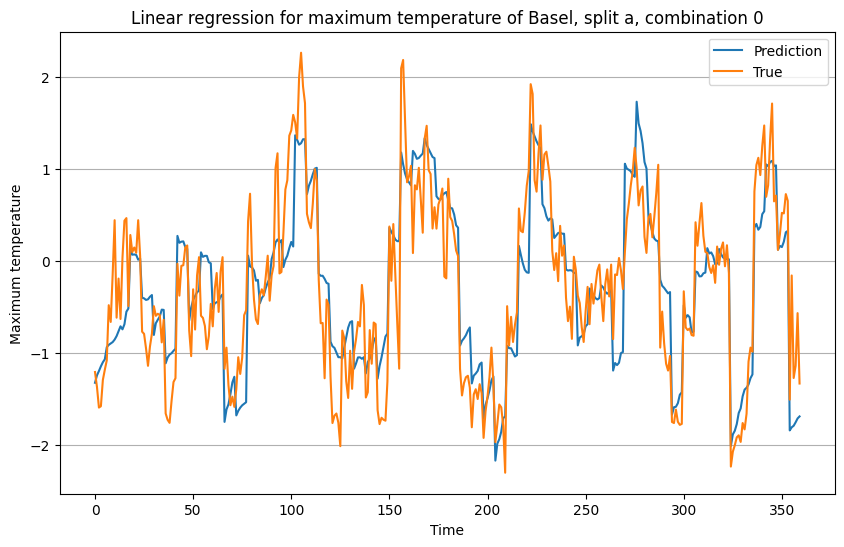

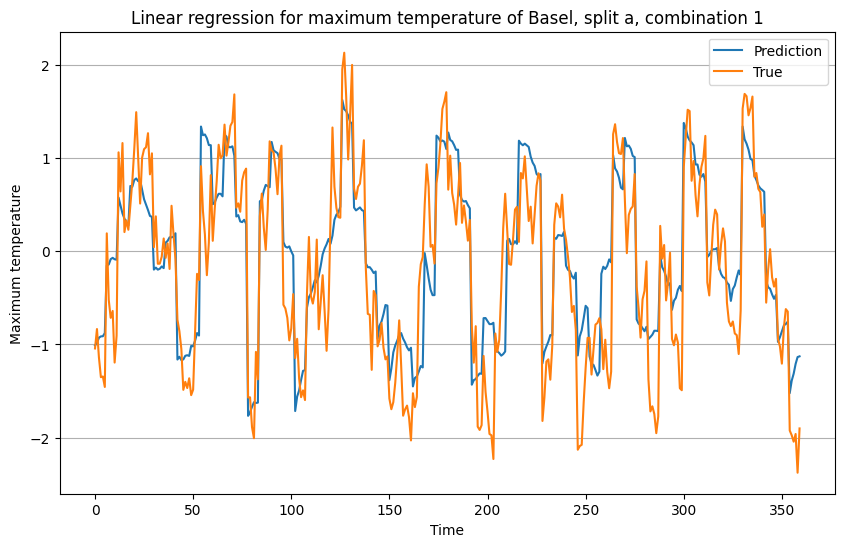

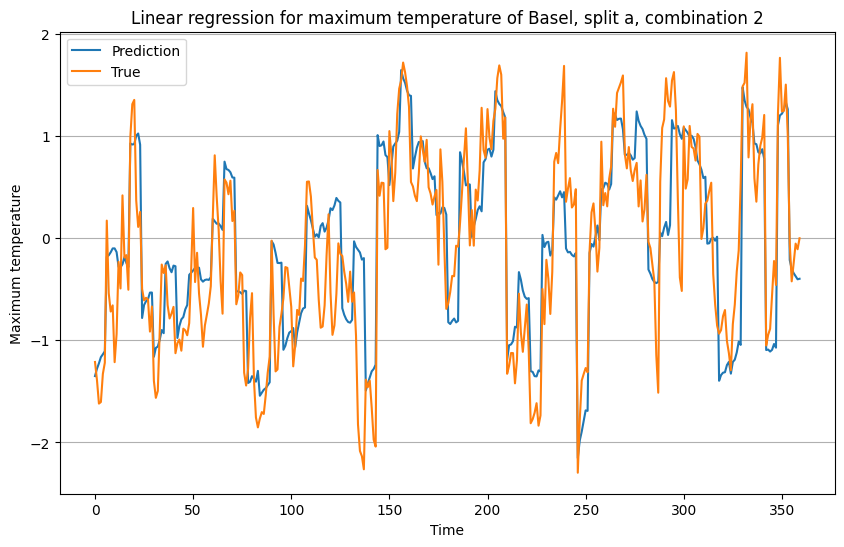

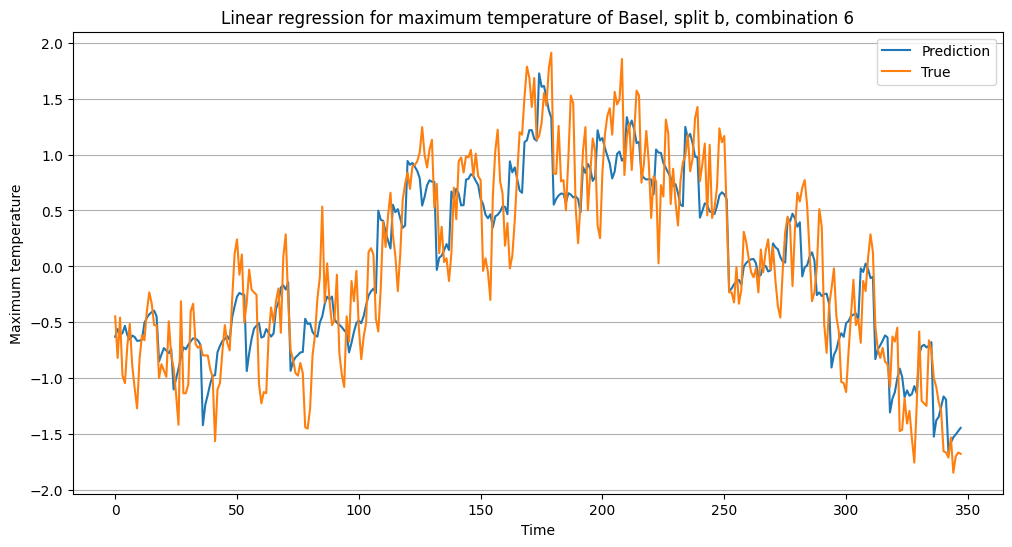

,Mean a,Std a,Mean b,Std b,Mean c,Std c,Mean d,Std d
Train,0.517,0.006,0.434,0.038,0.417,0.012,0.432,0.013
Validation,0.524,0.032,0.421,0.042,0.411,0.027,0.420,0.028
Test,0.523,0.032,0.425,0.043,0.411,0.027,0.421,0.028


In [13]:
europe = pd.read_csv("./Datasets/Europe dataset/weather_prediction_dataset.csv")
window_size = 6
output_size = 6
step_size = 6
feature = 'temp_max'
city = 'BASEL'
dataset = prepareDataFrames(europe, feature, city, window_size, output_size, step_size)
predictAndPlot(LinearRegression(), window_size, dataset)

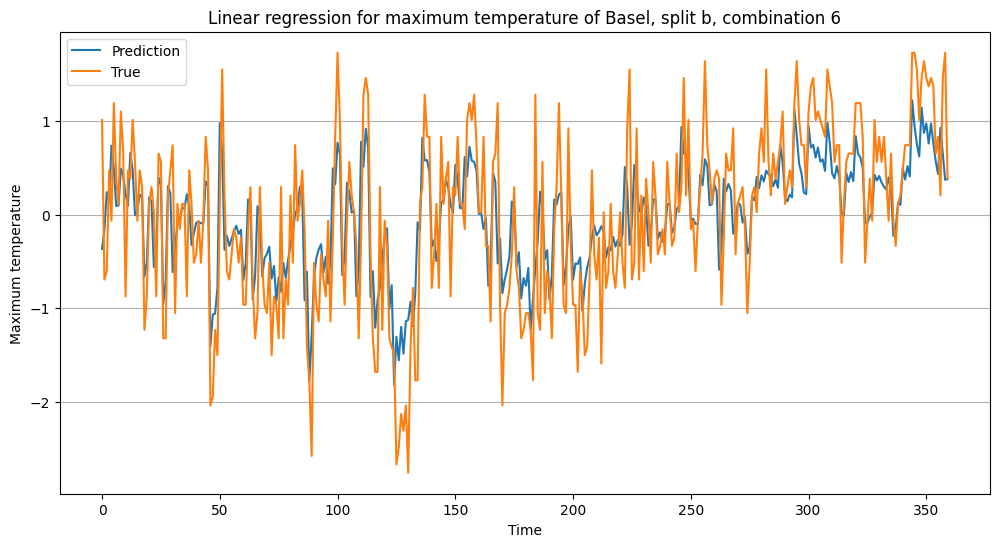

In [36]:
for i in range(len(cities_final)):
    values_train = []
    values_val = []
    values_test = []
    for j in range(len(cities_final[i])):
        lin_reg = lin_reg.fit(cities_final[i][j][0].iloc[:, :window_size], cities_final[i][j][0].iloc[:, window_size:])
        pred_train = lin_reg.predict(cities_final[i][j][0].iloc[:, :window_size]).flatten()
        pred_val = lin_reg.predict(cities_final[i][j][1].iloc[:, :window_size]).flatten()
        pred_test = lin_reg.predict(cities_final[i][j][2].iloc[:, :window_size]).flatten()

        true_train = cities_final[i][j][0].iloc[:, window_size:].to_numpy().flatten()
        true_val = cities_final[i][j][1].iloc[:, window_size:].to_numpy().flatten()
        true_test = cities_final[i][j][2].iloc[:, window_size:].to_numpy().flatten()

        # if i == 0 and j == 0:
        #     new_df = pd.DataFrame(cities_final[i][j][2]['y0'])
        #     new_df['predictions'] = pred_test
        #     with open('results.pkl', 'wb') as f:
        #         pickle.dump(new_df, f)

        if i == 0 and j == 6:
            plt.figure(figsize=(12, 6))
            plt.plot(range(len(pred_test[window_size:])), pred_test[window_size:], label='Prediction')
            plt.plot(range(len(true_test[:-window_size])), true_test[:-window_size], label='True')
            plt.xlabel('Time')
            plt.ylabel('Maximum temperature')
            plt.grid(axis='y')
            plt.title('Linear regression for maximum temperature of Basel, split {}, combination {}'.format(split[i], j))
            plt.legend()
            plt.show()

        rmse_lin_reg_train = mean_squared_error(true_train[:-window_size], pred_train[window_size:], squared=False)
        values_train.append(rmse_lin_reg_train)

        rmse_lin_reg_val = mean_squared_error(true_val[:-window_size], pred_val[window_size:], squared=False)
        values_val.append(rmse_lin_reg_val)

        rmse_lin_reg_test = mean_squared_error(true_test[:-window_size], pred_test[window_size:], squared=False)
        values_test.append(rmse_lin_reg_test)

    table_lin_reg['Mean {}'.format(split[i])] = [np.mean(values_train), np.mean(values_val), np.mean(values_test)]
    table_lin_reg['Std {}'.format(split[i])] = [np.std(values_train), np.std(values_val), np.std(values_test)]

In [37]:
table_lin_reg = table_lin_reg.round(3)
table_lin_reg.rename(index={0: 'Train', 1:'Validation', 2:'Test'})

,Mean a,Std a,Mean b,Std b,Mean c,Std c,Mean d,Std d
Train,0.805,0.005,0.621,0.054,0.614,0.017,0.616,0.013
Validation,0.805,0.035,0.631,0.097,0.616,0.066,0.620,0.046
Test,0.807,0.035,0.619,0.121,0.616,0.066,0.620,0.046


##### Support Vector Regressor

In [ ]:
svr = SVR()
for i in range(len(cities_final)):
    values_train = []
    values_val = []
    values_test = []
    for j in range(len(cities_final[i])):
        svr = svr.fit(cities_final[i][j][0].iloc[:, :-1], cities_final[i][j][0]['y0'])
        pred_train = svr.predict(cities_final[i][j][0].iloc[:, :-1])
        pred_val = svr.predict(cities_final[i][j][1].iloc[:, :-1])
        pred_test = svr.predict(cities_final[i][j][2].iloc[:, :-1])

        rmse_svr_train = mean_squared_error(cities_final[i][j][0]['y0'], pred_train, squared=False)
        values_train.append(rmse_svr_train)

        rmse_svr_val = mean_squared_error(cities_final[i][j][1]['y0'], pred_val, squared=False)
        values_val.append(rmse_svr_val)

        rmse_svr_test = mean_squared_error(cities_final[i][j][2]['y0'], pred_test, squared=False)
        values_test.append(rmse_svr_test)

    print('Train data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_train), np.std(values_train)))
    print('Validation data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_val), np.std(values_val)))
    print('Test data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_test), np.std(values_test)))

Train data b split: mean -> 3.1430100319455567, std -> 0.05075494221157843
Validation data b split: mean -> 3.304017865512319, std -> 0.48611185746367575
Test data b split: mean -> 3.3249097523331566, std -> 0.5864857808759385
Train data c split: mean -> 3.090186515576104, std -> 0.025934936948628307
Validation data c split: mean -> 3.153322638835007, std -> 0.25595024251726606
Test data c split: mean -> 3.1533226388350064, std -> 0.25595024251726606
Train data d split: mean -> 3.1646916837316357, std -> 0.040530373691584826
Validation data d split: mean -> 3.1464675773674005, std -> 0.18460453174337746
Test data d split: mean -> 3.1482782459121443, std -> 0.1814471743802419


In [18]:
values_train = []
values_val = []
values_test = []
for i in range(len(cities_a)):
    svr = svr.fit(cities_a[i][0].iloc[:, :-1], cities_a[i][0]['y0'])
    pred_train = svr.predict(cities_a[i][0].iloc[:, :-1])
    pred_val = svr.predict(cities_a[i][1].iloc[:, :-1])
    pred_test = svr.predict(cities_a[i][2].iloc[:, :-1])

    rmse_svr_train = mean_squared_error(cities_a[i][0]['y0'], pred_train, squared=False)
    values_train.append(rmse_svr_train)

    rmse_svr_val = mean_squared_error(cities_a[i][1]['y0'], pred_val, squared=False)
    values_val.append(rmse_svr_val)

    rmse_svr_test = mean_squared_error(cities_a[i][2]['y0'], pred_test, squared=False)
    values_test.append(rmse_svr_test)

print('Train data a split: mean -> {}, std -> {}'.format(np.mean(values_train), np.std(values_train)))
print('Validation data a split: mean -> {}, std -> {}'.format(np.mean(values_val), np.std(values_val)))
print('Test data a split: mean -> {}, std -> {}'.format(np.mean(values_test), np.std(values_test)))

Train data a split: mean -> 3.086960185404355, std -> 0.019233877761985076
Validation data a split: mean -> 3.135026412788074, std -> 0.1180903505421646
Test data a split: mean -> 3.1290746607706432, std -> 0.11695193170399715


##### Random Forest Regressor

In [ ]:
random_forest = RandomForestRegressor()
for i in range(len(cities_final)):
    values_train = []
    values_val = []
    values_test = []
    for j in range(len(cities_final[i])):
        random_forest = random_forest.fit(cities_final[i][j][0].iloc[:, :-1], cities_final[i][j][0]['y0'])
        pred_train = random_forest.predict(cities_final[i][j][0].iloc[:, :-1])
        pred_val = random_forest.predict(cities_final[i][j][1].iloc[:, :-1])
        pred_test = random_forest.predict(cities_final[i][j][2].iloc[:, :-1])

        rmse_random_forest_train = mean_squared_error(cities_final[i][j][0]['y0'], pred_train, squared=False)
        values_train.append(rmse_random_forest_train)

        rmse_random_forest_val = mean_squared_error(cities_final[i][j][1]['y0'], pred_val, squared=False)
        values_val.append(rmse_random_forest_val)

        rmse_random_forest_test = mean_squared_error(cities_final[i][j][2]['y0'], pred_test, squared=False)
        values_test.append(rmse_random_forest_test)

    print('Train data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_train), np.std(values_train)))
    print('Validation data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_val), np.std(values_val)))
    print('Test data {} split: mean -> {}, std -> {}'.format(split[i], np.mean(values_test), np.std(values_test)))

In [ ]:
values_train = []
values_val = []
values_test = []
for i in range(len(cities_a)):
    random_forest = random_forest.fit(cities_a[i][0].iloc[:, :-1], cities_a[i][0]['y0'])
    pred_train = random_forest.predict(cities_a[i][0].iloc[:, :-1])
    pred_val = random_forest.predict(cities_a[i][1].iloc[:, :-1])
    pred_test = random_forest.predict(cities_a[i][2].iloc[:, :-1])

    rmse_random_forest_train = mean_squared_error(cities_a[i][0]['y0'], pred_train, squared=False)
    values_train.append(rmse_random_forest_train)

    rmse_random_forest_val = mean_squared_error(cities_a[i][1]['y0'], pred_val, squared=False)
    values_val.append(rmse_random_forest_val)

    rmse_random_forest_test = mean_squared_error(cities_a[i][2]['y0'], pred_test, squared=False)
    values_test.append(rmse_random_forest_test)

    # if i == 0:
    #     plt.plot(cities_a[i][2].index, pred_test)
    #     plt.plot(cities_a[i][2].index, cities_a[i][2]['y0'])
    #     plt.xlabel('Day')
    #     plt.ylabel('Maximum temperature')
    #     plt.grid(axis='y')
    #     plt.title('Artificial data for maximum temperature')
    #     plt.show()

print('Train data a split: mean -> {}, std -> {}'.format(np.mean(values_train), np.std(values_train)))
print('Validation data a split: mean -> {}, std -> {}'.format(np.mean(values_val), np.std(values_val)))
print('Test data a split: mean -> {}, std -> {}'.format(np.mean(values_test), np.std(values_test)))

#### III.2 Trying ML models on artificial data

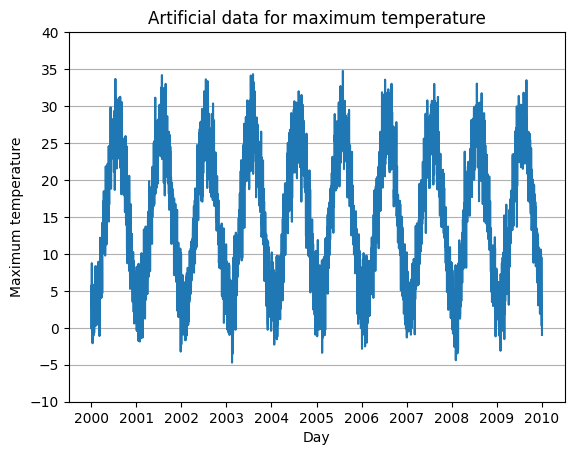

In [80]:
x = np.linspace(0, 20 * np.pi, 3654)
f = 12 * np.sin(x - 2) + np.random.normal(scale=3, size=len(x)) + 15
plt.plot(x / (2 * np.pi) + 2000, f)
plt.xlabel('Day')
plt.ylabel('Maximum temperature')
plt.xticks(np.arange(2000, 2010.1, step=1))
plt.yticks(np.arange(-10, 41, step=5))
plt.grid(axis='y')
plt.title('Artificial data for maximum temperature')
plt.show()

In [85]:
date_index = pd.date_range(start='01-01-2000', end='01-01-2010', periods=3654)
artificial_data = pd.DataFrame(np.round(f, decimals=1), index = date_index)
artificial_data.rename(columns={0: 'ARTIFICIAL_temp_max'}, inplace=True)

# cities_k.append(makeSlidingWindow(cities_split[i][j][k], window_size, output_size, step_size=21, column_name=cities_split[i][j][k].columns[0]))

artificial_split = []
for i in ['b', 'c', 'd']:
    artificial_split.append(allTemporalSplittings(artificial_data, i, sample_number=2000, period=365, seasons=4))

for i in range(len(artificial_split)):
    for j in range(len(artificial_split[i])):
        scaler = StandardScaler()
        artificial_split[i][j][0]['ARTIFICIAL_temp_max'] = scaler.fit_transform(artificial_split[i][j][0])
        artificial_split[i][j][1]['ARTIFICIAL_temp_max'] = scaler.transform(artificial_split[i][j][1])
        artificial_split[i][j][2]['ARTIFICIAL_temp_max'] = scaler.transform(artificial_split[i][j][2])

artificial_final = []
for i in range(len(artificial_split)):
    artificial_i = []
    for j in range(len(artificial_split[i])):
        artificial_j = []
        for k in range(len(artificial_split[i][j])):
            artificial_j.append(makeSlidingWindow(artificial_split[i][j][k], 1, 1, 1, artificial_data.columns[0]))
        artificial_i.append(artificial_j)
    artificial_final.append(artificial_i)

artificial_transformed = makeSlidingWindow(artificial_data, 1, 1, 1, artificial_data.columns[0])
artificial_a = allTemporalSplittings(artificial_transformed, 'a', sample_number=2000, period=365, seasons=4)

for i in range(len(artificial_a)):
    scaler = StandardScaler()
    artificial_a[i][0].iloc[:, :] = scaler.fit_transform(artificial_a[i][0])
    artificial_a[i][1].iloc[:, :] = scaler.transform(artificial_a[i][1])
    artificial_a[i][2].iloc[:, :] = scaler.transform(artificial_a[i][2])

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22968\2254628467.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artificial_split[i][j][0]['ARTIFICIAL_temp_max'] = scaler.fit_transform(artificial_split[i][j][0])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22968\2254628467.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artificial_split[i][j][1]['ARTIFICIAL_temp_max'] = scaler.transform(artificial_split[i][j][1])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykerne

In [48]:
len(artificial_transformed)

174

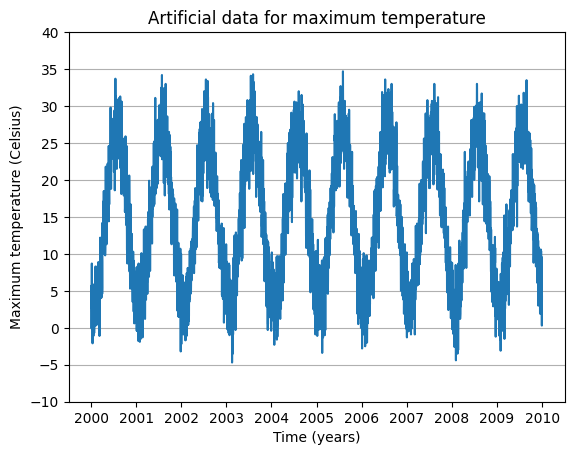

In [86]:
plt.plot(artificial_data['ARTIFICIAL_temp_max'])
plt.xlabel('Time (years)')
plt.ylabel('Maximum temperature (Celsius)')
plt.yticks(np.arange(-10, 41, step=5))
plt.grid(axis='y')
plt.title('Artificial data for maximum temperature')
plt.show()

##### Linear Regression

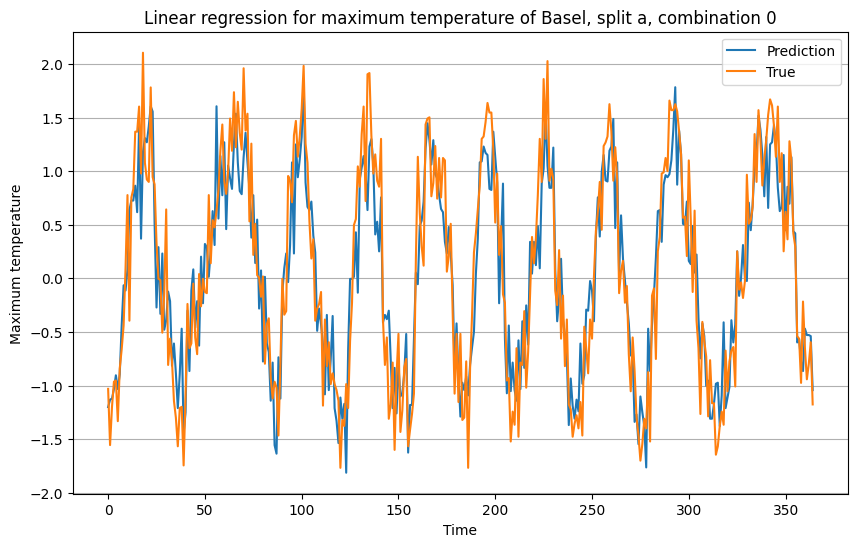

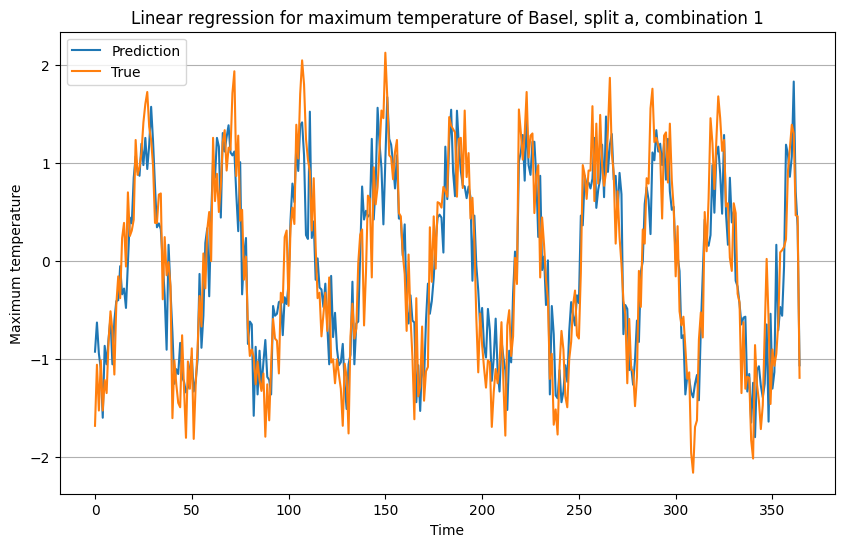

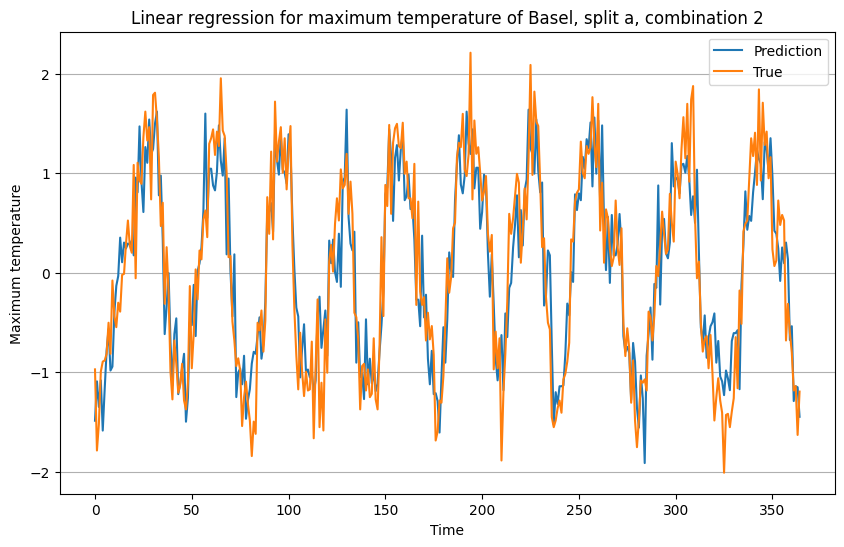

In [90]:
# lin_reg = LinearRegression()
# for i in range(len(artificial_final)):
#     lin_reg = lin_reg.fit(artificial_final[i][0].iloc[:, :-1], artificial_final[i][0]['y0'])
#     pred_train = lin_reg.predict(artificial_final[i][0].iloc[:, :-1])
#     pred_val = lin_reg.predict(artificial_final[i][1].iloc[:, :-1])
#     pred_test = lin_reg.predict(artificial_final[i][2].iloc[:, :-1])

#     rmse_lin_reg_train = mean_squared_error(artificial_final[i][0]['y0'], pred_train, squared=False)
#     print("RMSE for Linear Regression for train data for artifical on split {} is: ".format(split[i]), rmse_lin_reg_train)

#     rmse_lin_reg_val = mean_squared_error(artificial_final[i][1]['y0'], pred_val, squared=False)
#     print("RMSE for Linear Regression for validation data for artificial on split {} is: ".format(split[i]), rmse_lin_reg_val)

#     rmse_lin_reg_test = mean_squared_error(artificial_final[i][2]['y0'], pred_test, squared=False)
#     print("RMSE for Linear Regression for test data for artificial on split {} is: ".format(split[i]), rmse_lin_reg_test)

values_train = []
values_val = []
values_test = []
lin_reg = LinearRegression()
table_lin_reg = pd.DataFrame()
for i in range(len(artificial_a)):
    lin_reg = lin_reg.fit(artificial_a[i][0].iloc[:, :window_size], artificial_a[i][0].iloc[:, window_size:])
    pred_train = lin_reg.predict(artificial_a[i][0].iloc[:, :window_size]).flatten()
    pred_val = lin_reg.predict(artificial_a[i][1].iloc[:, :window_size]).flatten()
    pred_test = lin_reg.predict(artificial_a[i][2].iloc[:, :window_size]).flatten()

    true_train = artificial_a[i][0].iloc[:, window_size:].to_numpy().flatten()
    true_val = artificial_a[i][1].iloc[:, window_size:].to_numpy().flatten()
    true_test = artificial_a[i][2].iloc[:, window_size:].to_numpy().flatten()

    if i <= 2:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(pred_test)), pred_test, label='Prediction')
        plt.plot(range(len(true_test)), true_test, label='True')
        plt.xlabel('Time')
        plt.ylabel('Maximum temperature')
        plt.grid(axis='y')
        plt.title('Linear regression for maximum temperature of Basel, split a, combination {}'.format(i))
        plt.legend()
        plt.show()


    rmse_lin_reg_train = mean_squared_error(artificial_a[i][0].iloc[:, window_size:], pred_train, squared=False)
    values_train.append(rmse_lin_reg_train)

    rmse_lin_reg_val = mean_squared_error(artificial_a[i][1].iloc[:, window_size:], pred_val, squared=False)
    values_val.append(rmse_lin_reg_val)

    rmse_lin_reg_test = mean_squared_error(artificial_a[i][2].iloc[:, window_size:], pred_test, squared=False)
    values_test.append(rmse_lin_reg_test)

table_lin_reg['Mean a'] = [np.mean(values_train), np.mean(values_val), np.mean(values_test)]
table_lin_reg['Std a'] = [np.std(values_train), np.std(values_val), np.std(values_test)]

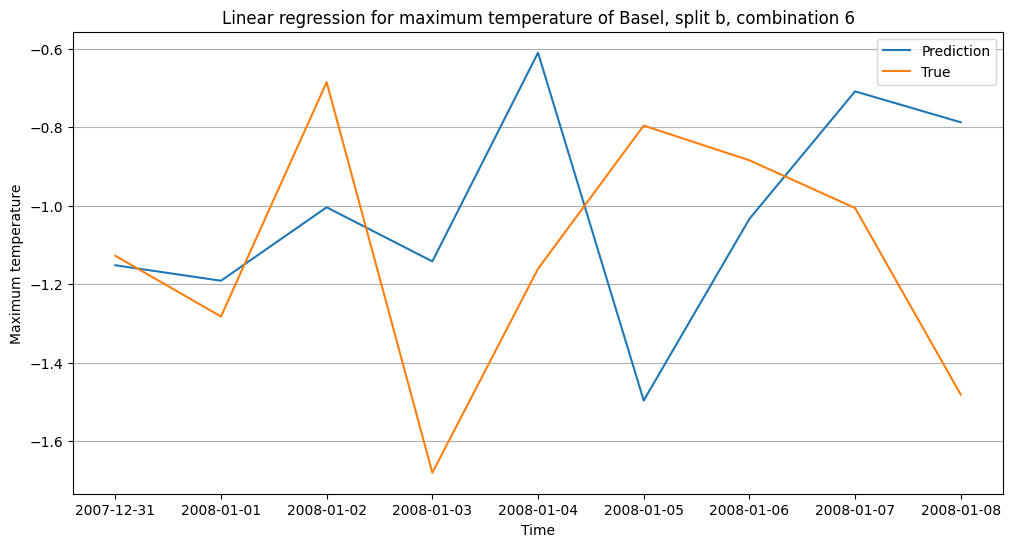

In [108]:
for i in range(len(artificial_final) - 2):
    values_train = []
    values_val = []
    values_test = []
    for j in range(len(artificial_final[i])):
        lin_reg = lin_reg.fit(artificial_final[i][j][0].iloc[:, :window_size], artificial_final[i][j][0].iloc[:, window_size:])
        pred_train = lin_reg.predict(artificial_final[i][j][0].iloc[:, :window_size]).flatten()
        pred_val = lin_reg.predict(artificial_final[i][j][1].iloc[:, :window_size]).flatten()
        pred_test = lin_reg.predict(artificial_final[i][j][2].iloc[:, :window_size]).flatten()

        true_train = artificial_final[i][j][0].iloc[:, window_size:].to_numpy().flatten()
        true_val = artificial_final[i][j][1].iloc[:, window_size:].to_numpy().flatten()
        true_test = artificial_final[i][j][2].iloc[:, window_size:].to_numpy().flatten()

        # if i == 0 and j == 0:
        #     new_df = pd.DataFrame(cities_final[i][j][2]['y0'])
        #     new_df['predictions'] = pred_test
        #     with open('results.pkl', 'wb') as f:
        #         pickle.dump(new_df, f)

        if i == 0 and j == 6:
            plt.figure(figsize=(12, 6))
            plt.plot(artificial_final[i][j][2].index[1:10], pred_test[:9], label='Prediction')
            plt.plot(artificial_final[i][j][2].index[1:10], true_test[1:10], label='True')
            plt.xlabel('Time')
            plt.ylabel('Maximum temperature')
            plt.grid(axis='y')
            plt.title('Linear regression for maximum temperature of Basel, split {}, combination {}'.format(split[i], j))
            plt.legend()
            plt.show()

        rmse_lin_reg_train = mean_squared_error(true_train[window_size:], pred_train[:-window_size], squared=False)
        values_train.append(rmse_lin_reg_train)

        rmse_lin_reg_val = mean_squared_error(true_val[:-window_size], pred_val[window_size:], squared=False)
        values_val.append(rmse_lin_reg_val)

        rmse_lin_reg_test = mean_squared_error(true_test[:-window_size], pred_test[window_size:], squared=False)
        values_test.append(rmse_lin_reg_test)

    table_lin_reg['Mean {}'.format(split[i])] = [np.mean(values_train), np.mean(values_val), np.mean(values_test)]
    table_lin_reg['Std {}'.format(split[i])] = [np.std(values_train), np.std(values_val), np.std(values_test)]

In [109]:
table_lin_reg.rename(index={0: 'Train', 1:'Validation', 2:'Test'})

,Mean a,Std a,Mean b,Std b,Mean c,Std c,Mean d,Std d
Train,0.454524,0.002800,0.447301,0.012759,0.453546,0.003862,0.462199,0.003393
Validation,0.454497,0.016112,0.107022,0.006577,0.452719,0.025404,0.453190,0.018428
Test,0.454275,0.016202,0.104970,0.005720,0.452719,0.025404,0.454022,0.018500


In [ ]:
lin_reg = lin_reg.fit(artificial_a[0].iloc[:, :-1], artificial_a[0]['y0'])
pred_train = lin_reg.predict(artificial_a[0].iloc[:, :-1])
pred_val = lin_reg.predict(artificial_a[1].iloc[:, :-1])
pred_test = lin_reg.predict(artificial_a[2].iloc[:, :-1])

rmse_lin_reg_train = mean_squared_error(artificial_a[0]['y0'], pred_train, squared=False)
print("RMSE for Linear Regression for train data for artifical on split a is: ", rmse_lin_reg_train)

rmse_lin_reg_val = mean_squared_error(artificial_a[1]['y0'], pred_val, squared=False)
print("RMSE for Linear Regression for validation data for artificial on split a is: ", rmse_lin_reg_val)

rmse_lin_reg_test = mean_squared_error(artificial_a[2]['y0'], pred_test, squared=False)
print("RMSE for Linear Regression for test data for artificial on split a is: ", rmse_lin_reg_test)

RMSE for Linear Regression for train data for artifical on split a is:  3.2586356255808306
RMSE for Linear Regression for validation data for artificial on split a is:  3.4053069675867986
RMSE for Linear Regression for test data for artificial on split a is:  3.2094314946555476


##### Support Vector Regressor

In [ ]:
svr = SVR()
for i in range(len(artificial_final)):
    svr = svr.fit(artificial_final[i][0].iloc[:, :-1], artificial_final[i][0]['y0'])
    pred_train = svr.predict(artificial_final[i][0].iloc[:, :-1])
    pred_val = svr.predict(artificial_final[i][1].iloc[:, :-1])
    pred_test = svr.predict(artificial_final[i][2].iloc[:, :-1])

    rmse_svr_train = mean_squared_error(artificial_final[i][0]['y0'], pred_train, squared=False)
    print("RMSE for Support Vector Machine for training data on split {} is: ".format(split[i]), rmse_svr_train)

    rmse_svr_val = mean_squared_error(artificial_final[i][1]['y0'], pred_val, squared=False)
    print("RMSE for Support Vector Machine for validation data on split {} is: ".format(split[i]), rmse_svr_val)

    rmse_svr_test = mean_squared_error(artificial_final[i][2]['y0'], pred_test, squared=False)
    print("RMSE for Support Vector Machine for test data on split {} is: ".format(split[i]), rmse_svr_test)

RMSE for Support Vector Machine for training data on split b is:  3.24815191708288
RMSE for Support Vector Machine for validation data on split b is:  3.210740996017895
RMSE for Support Vector Machine for test data on split b is:  3.406086731510035
RMSE for Support Vector Machine for training data on split c is:  3.2302991111087094
RMSE for Support Vector Machine for validation data on split c is:  3.3343817338893214
RMSE for Support Vector Machine for test data on split c is:  3.296135033785469
RMSE for Support Vector Machine for training data on split d is:  3.386587877328416
RMSE for Support Vector Machine for validation data on split d is:  3.6134048813798576
RMSE for Support Vector Machine for test data on split d is:  4.098163999094724


In [ ]:
svr = svr.fit(artificial_a[0].iloc[:, :-1], artificial_a[0]['y0'])
pred_train = svr.predict(artificial_a[0].iloc[:, :-1])
pred_val = svr.predict(artificial_a[1].iloc[:, :-1])
pred_test = svr.predict(artificial_a[2].iloc[:, :-1])

rmse_svr_train = mean_squared_error(artificial_a[0]['y0'], pred_train, squared=False)
print("RMSE for Linear Regression for train data for artifical on split a is: ", rmse_svr_train)

rmse_svr_val = mean_squared_error(artificial_a[1]['y0'], pred_val, squared=False)
print("RMSE for Linear Regression for validation data for artificial on split a is: ", rmse_svr_val)

rmse_svr_test = mean_squared_error(artificial_a[2]['y0'], pred_test, squared=False)
print("RMSE for Linear Regression for test data for artificial on split a is: ", rmse_svr_test)

RMSE for Linear Regression for train data for artifical on split a is:  3.2311825392909217
RMSE for Linear Regression for validation data for artificial on split a is:  3.408910553226792
RMSE for Linear Regression for test data for artificial on split a is:  3.238185518316089


##### Random Forest

In [ ]:
random_forest = RandomForestRegressor()
for i in range(len(artificial_final)):
    random_forest = random_forest.fit(artificial_final[i][0].iloc[:, :-1], artificial_final[i][0]['y0'])
    pred_train = random_forest.predict(artificial_final[i][0].iloc[:, :-1])
    pred_val = random_forest.predict(artificial_final[i][1].iloc[:, :-1])
    pred_test = random_forest.predict(artificial_final[i][2].iloc[:, :-1])

    rmse_random_forest_train = mean_squared_error(artificial_final[i][0]['y0'], pred_train, squared=False)
    print("RMSE for Random Forest for training data on split {} is: ".format(i+1), rmse_random_forest_train)

    rmse_random_forest_val = mean_squared_error(artificial_final[i][1]['y0'], pred_val, squared=False)
    print("RMSE for Random Forest for validation data on split {} is: ".format(i+1), rmse_random_forest_val)

    rmse_random_forest_test = mean_squared_error(artificial_final[i][2]['y0'], pred_test, squared=False)
    print("RMSE for Random Forest for test data on split {} is: ".format(i+1), rmse_random_forest_test)

RMSE for Random Forest for training data on split 1 is:  1.272074408139325
RMSE for Random Forest for validation data on split 1 is:  3.3434076113012696
RMSE for Random Forest for test data on split 1 is:  3.4798976980403915
RMSE for Random Forest for training data on split 2 is:  1.2576994615369057
RMSE for Random Forest for validation data on split 2 is:  3.4170733761657153
RMSE for Random Forest for test data on split 2 is:  3.318542639262505
RMSE for Random Forest for training data on split 3 is:  1.305146546713832
RMSE for Random Forest for validation data on split 3 is:  3.5316928767121007
RMSE for Random Forest for test data on split 3 is:  3.8543040662609287


In [ ]:
random_forest = random_forest.fit(artificial_a[0].iloc[:, :-1], artificial_a[0]['y0'])
pred_train = random_forest.predict(artificial_a[0].iloc[:, :-1])
pred_val = random_forest.predict(artificial_a[1].iloc[:, :-1])
pred_test = random_forest.predict(artificial_a[2].iloc[:, :-1])

rmse_random_forest_train = mean_squared_error(artificial_a[0]['y0'], pred_train, squared=False)
print("RMSE for Linear Regression for train data for artifical on split a is: ", rmse_random_forest_train)

rmse_random_forest_val = mean_squared_error(artificial_a[1]['y0'], pred_val, squared=False)
print("RMSE for Linear Regression for validation data for artificial on split a is: ", rmse_random_forest_val)

rmse_random_forest_test = mean_squared_error(artificial_a[2]['y0'], pred_test, squared=False)
print("RMSE for Linear Regression for test data for artificial on split a is: ", rmse_random_forest_test)

RMSE for Linear Regression for train data for artifical on split a is:  1.2596181408728229
RMSE for Linear Regression for validation data for artificial on split a is:  3.538249266407452
RMSE for Linear Regression for test data for artificial on split a is:  3.3419729026716807


### IV. Spatial splitting strategies

In [39]:
europe = pd.read_csv("./Datasets/Europe dataset/weather_prediction_dataset.csv")
europe = europe.drop(columns=['MONTH'])
europe['DATE'] = pd.to_datetime(europe["DATE"], format="%Y%m%d")

In [40]:
europe

,DATE,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,2000-01-01,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,2000-01-02,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,2000-01-03,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,2000-01-04,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,2000-01-05,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009-12-28,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,2009-12-29,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,2009-12-30,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,2009-12-31,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9
